In [2]:
import tensorflow as tf
import keras as k
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import cv2
import os
from PIL import Image
print(Image.__file__)
from sklearn.preprocessing import LabelEncoder

from keras.applications import VGG16
from keras import optimizers
from tensorflow.keras.applications.xception import (Xception, preprocess_input, decode_predictions)


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py


In [3]:

INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
TARGET_SIZE = INPUT_SHAPE[:2]
EPOCHS = 3

BASE_DIR_PATH = './data/'
MODEL_FILENAME = 'model_fruit_fresh_rotten'
PATH_TO_TRAINED_MODEL_FILE = './model/' + MODEL_FILENAME + '.h5'

vgg16_model = VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)


58892288/58889256 [==============================] - 15s 0us/step


In [8]:
#build path to base dir
base_dir_path = BASE_DIR_PATH

#build path to train dir
train_dir_path = os.path.join(base_dir_path,'train')

#build path to test dir
test_dir_path = os.path.join(base_dir_path,'test')

In [9]:
print (base_dir_path)
print(train_dir_path)
print(test_dir_path)

./data/
./data/train
./data/test


In [10]:
def classesFromData():
    """
    Console output of,
        total number of classes in train/test dir
        total number of images in train/test dir
    in given dataset.
    
    Returns number of classes
    """
    nb_of_train_files = 0
    nb_of_test_files = 0
    AllClassNames_train = os.listdir(train_dir_path)
    AllClassNames_test = os.listdir(test_dir_path)
    
    print('Total Number of Classes in train DataSet: ', len(AllClassNames_train))
    print('Total Number of Classes in test DataSet: ', len(AllClassNames_test))
    
    for class_name in AllClassNames_train:
        nb_of_train_files = nb_of_train_files + len(os.listdir(os.path.join(train_dir_path, class_name)))
        nb_of_test_files = nb_of_test_files + len(os.listdir(os.path.join(test_dir_path, class_name)))
        
    print('Total Number of train samples: ', nb_of_train_files)
    print('Total Number of test samples:', nb_of_test_files)
    
    return len(AllClassNames_train)

In [11]:
num_of_classes = classesFromData()
print(num_of_classes)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './data/train'

In [8]:
def getAllClassNames(dir_path):
    """
        Returns list of all class names in given train/test dir path.
    """
    return os.listdir(dir_path)


In [8]:
def compile_classify_model(num_of_classes):
    model = Sequential()
    model.add(vgg16_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=6, activation='softmax'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-5),
                  metrics=['accuracy'])
    model.summary()
    
    return model


In [9]:

def train_classify_model(classify_model,
                         batch_size = BATCH_SIZE, 
                         save_model_filename = MODEL_FILENAME, 
                         input_size = (BATCH_SIZE, BATCH_SIZE)):
    
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       zoom_range=0.3, 
                                       rotation_range=50,
                                       width_shift_range=0.2, 
                                       height_shift_range=0.2, 
                                       shear_range=0.2, 
                                       horizontal_flip=True, 
                                       fill_mode='nearest')
    
    val_datagen = ImageDataGenerator(rescale = 1./255)

    train_generator = train_datagen.flow_from_directory(train_dir_path,
                                                         target_size = TARGET_SIZE,
                                                         batch_size = BATCH_SIZE,
                                                         class_mode = 'categorical')
#                                                       class_mode = 'binary')

    val_generator = val_datagen.flow_from_directory(test_dir_path,
                                                    target_size = TARGET_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical')
#                                                     class_mode = 'binary')

    #construct fit generator
    history = classify_model.fit_generator(train_generator, epochs=EPOCHS, 
                                       steps_per_epoch = train_generator.n // BATCH_SIZE,
                                       validation_data=val_generator,
                                       validation_steps = val_generator.n // BATCH_SIZE,
                                       verbose=1)
    
    class_dict = train_generator.class_indices
    np.save('class_dict', class_dict)
    trainedModel_Filename = SaveModelFile(classify_model, save_model_filename)
    return history, trainedModel_Filename

In [10]:
def SaveModelFile(classify_model, save_model_filename):
    """
    Saves trained classification model

    """

    save_model_filename = save_model_filename + '.h5'
    classify_model.save(save_model_filename)
    print('Done Saving Model File...')
    return save_model_filename

def getTrainedModel(PATH_TO_TRAINED_MODEL_FILE):
    """
    Loads trained-saved model from file(.h5) and returns as a object.

    """
    trainedModel = load_model(PATH_TO_TRAINED_MODEL_FILE)
    return trainedModel



# Compile classification model

In [11]:

classifyModel=compile_classify_model(num_of_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                8208      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
Total params: 14,722,998
Trainable params: 14,722,998
Non-trainable params: 0
_________________________________________________________________


# Train the model on train dataset

In [12]:

training_history,trained_model_path = train_classify_model(classifyModel)


Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.
Epoch 1/3
340/340 [==============================] - 362s 1s/step - loss: 0.1456 - acc: 0.9438 - val_loss: 0.0510 - val_acc: 0.9812
Epoch 2/3
340/340 [==============================] - 360s 1s/step - loss: 0.0452 - acc: 0.9841 - val_loss: 0.0311 - val_acc: 0.9886
Epoch 3/3
340/340 [==============================] - 354s 1s/step - loss: 0.0257 - acc: 0.9913 - val_loss: 0.0075 - val_acc: 0.9978
Done Saving Model File...


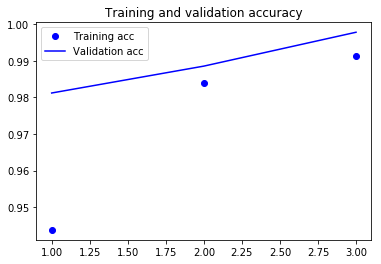

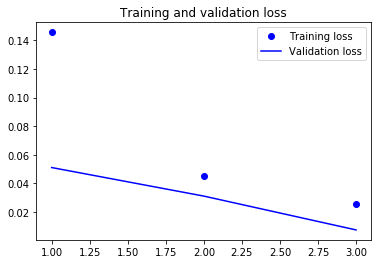

In [18]:
#Plot the training results
acc = training_history.history['acc']
val_acc = training_history.history['val_acc']
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [61]:
def predictFruitClass(ImagePath, trainedModel, class_dict):
    """
    Perform class prediction on input image and print predicted class.

    Args:
        ImagePath(str): Absolute Path to test image
        trainedModel(object): trained model from method getTrainedModel()
        DictOfClasses(dict): python dict of all image classes.

    Returns:
        Probability of predictions for each class.
    """
    x = image.load_img(ImagePath, target_size=TARGET_SIZE)
    x = image.img_to_array(x)

#     plt.imshow((x * 255).astype(np.uint8))
    plt.imshow((x).astype(np.uint16))
    x = np.expand_dims(x, axis=0)

    prediction_class = trainedModel.predict_classes(x, batch_size=1)
    prediction_probs = trainedModel.predict_proba(x, batch_size=1)
    print('probabilities:',prediction_probs)
    print('class_index:',prediction_class[0])

    for key, value in class_dict.items():
        if value == prediction_class.item():
            return key
    return None
    

In [71]:
trained_model_path = PATH_TO_TRAINED_MODEL_FILE
trained_model = getTrainedModel(trained_model_path)
class_dict = np.load('class_dict.npy', allow_pickle=True).item()

# Test the model

probabilities: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 5.9647023e-28 0.0000000e+00
  1.0000000e+00]]
class_index: 5
rottenoranges


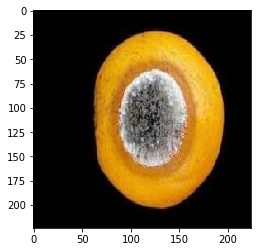

In [84]:
# image_path = './data/test/rottenapples/rotated_by_15_Screen Shot 2018-06-07 at 2.25.26 PM.png'

image_path = './data/test/test/ro2.jpg'

single_pred = predictFruitClass(image_path,trained_model, class_dict)
print(single_pred)
